In [1]:
import MLForecast.sources
import MLForecast.preprocessing as prep
import MLForecast.normalize
import MLForecast.networks
import MLForecast.postprocessing
import MLForecast.visualize
from datetime import datetime
import pandas as pd
import wandb

# Login to W&B
Only required once per computer uptime!

In [2]:
wandb.login()

wandb: Currently logged in as: leuchtum (use `wandb login --relogin` to force relogin)


True

# Set parameters

In [3]:
X_WIDTH = 200
Y_WIDTH = 12
SHIFT = 200
INTERPOLATE = 4
SPLIT = (.05, .3, .65) # TEST, VAL, TRAIN
LABEL_COLUMNS = ["WX_15444", "WY_15444"]
EPOCHS = 6
EARLY_STOP = 2

structure = ["LSTM_x", "DROP_d", "DENSE_y", "OUT"]
network_config = {
    #"LSTM": {
    #    "recurrent_regularizer": "L1_0.0001"
    #},
    "x": 64,
    "y": 64,
    "d": 0.3
}

# Make Dataset
This may take a while

In [4]:
print("LOAD")
dwd = MLForecast.sources.DWDStationsHourly(["15444", "04887"], ["wind", "air_temperature", "pressure", "sun"])
df_dwd = dwd.get_data(drop_before=datetime(2017,1,1))
cal = MLForecast.sources.CalendricalDataHourly(start=datetime(2014,1,1))
df_cal = cal.get_data()

df = pd.concat([df_dwd, df_cal], axis=1)


print("INTERPOLATE AND POL2CART")
df = prep.interpolate_columnwise(df, INTERPOLATE)
df =  prep.pol2cart(df)

print("FIT NORMALIZER")
spezial_borders = {
    "WX": (-1, 1),
    "WY": (-1, 1)
}
exclude = ["CAL"]
norm = MLForecast.normalize.MinMaxNormalizer(spezial_border=spezial_borders, exclude=exclude)
norm.fit(df)

print("MAKE X_DF AND Y_DF")
df_x = norm.normalize(df)
df_y = df[LABEL_COLUMNS]

print("SAMPLE")
x, y =  prep.sample_sequences(df_x, df_y, X_WIDTH, Y_WIDTH, SHIFT)


print("SPLIT")
test, val, train =  prep.split_test_val_train(x, y, SPLIT)

test_np =  prep.df_tuple_to_np(test)
val_np =  prep.df_tuple_to_np(val)
train_np =  prep.df_tuple_to_np(train)

LOAD
CHECK FOR NEW FILES AT https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/
15444:   0%|          | 0/8 [00:00<?, ?it/s]DOWNLOAD FILES
READ IN
04887: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it]
INTERPOLATE AND POL2CART
FIT NORMALIZER
MAKE X_DF AND Y_DF
 20%|██        | 658/3213 [00:00<00:00, 6573.55it/s]SAMPLE

100%|██████████| 328/328 [00:00<00:00, 5999.75it/s]

100%|██████████| 165/165 [00:00<00:00, 5346.61it/s]

100%|██████████| 569/569 [00:00<00:00, 6401.95it/s]

100%|██████████| 12/12 [00:06<00:00,  1.85it/s]
SPLIT


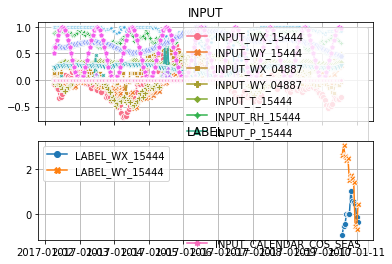

In [5]:
MLForecast.visualize.plot_input_label_example(x[30], y[30])

# Init W&B

In [5]:
database_report =  prep.DataBaseReport(df_x, df_y, x, y, SHIFT, SPLIT).report()

wandb_config = {
    "structure":structure,
    "config":network_config,
    "database": database_report,
    "epochs": EPOCHS,
    "early_stop": EARLY_STOP,
}

wandb.init(
    project='windprognose',
    entity='leuchtum',
    notes="test",
    config=wandb_config,
)

# Build and train model

In [6]:
my_model = MLForecast.networks.LSTMseq2vec(structure, network_config)
my_model.set_input_shape(train[0][0].shape)
my_model.set_output_shape(train[1][0].shape)
my_model.build()
my_model.compile()

my_model.fit(train_np, val_np, early_stop=EARLY_STOP, epochs=EPOCHS, track_wandb=True)

Epoch 1/6
749/749 [==============================] - 67s 88ms/step - loss: 3.2772 - mean_absolute_error: 1.3665 - mean_squared_error: 3.2772 - val_loss: 2.2755 - val_mean_absolute_error: 1.1275 - val_mean_squared_error: 2.2755
Epoch 2/6
749/749 [==============================] - 72s 96ms/step - loss: 2.2930 - mean_absolute_error: 1.1318 - mean_squared_error: 2.2930 - val_loss: 2.1336 - val_mean_absolute_error: 1.0807 - val_mean_squared_error: 2.1336
Epoch 3/6
749/749 [==============================] - 68s 90ms/step - loss: 2.1710 - mean_absolute_error: 1.0934 - mean_squared_error: 2.1710 - val_loss: 2.1329 - val_mean_absolute_error: 1.0839 - val_mean_squared_error: 2.1329
Epoch 4/6
749/749 [==============================] - 69s 92ms/step - loss: 2.1073 - mean_absolute_error: 1.0765 - mean_squared_error: 2.1073 - val_loss: 2.1015 - val_mean_absolute_error: 1.0779 - val_mean_squared_error: 2.1015
Epoch 5/6
749/749 [==============================] - 66s 89ms/step - loss: 2.0175 - mean_abs

# Analyse performance

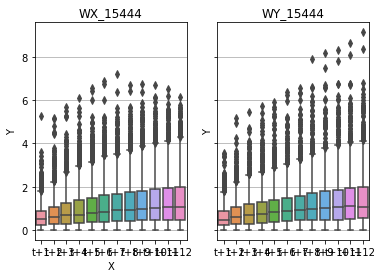

In [7]:
performance = MLForecast.postprocessing.PerformanceAnalyser(my_model.model, test_np)
mae_all = performance.by_metrics("mae")
mae_single = performance.by_metrics("mae", by_individual_column=True)

performance_report = performance.report()

MLForecast.visualize.boxplot(mae_single, LABEL_COLUMNS, "X", "Y")